# 📘 **LSE CFM Pre-Doctoral RA Application - Assessments** 
**Author:** Shreyas Urgunde
**Objective:** Complete the empirical analysis outlined in Task A and C   
**Date:** January 2026  
**Data Sources:** Eurostat

---


### **Project Structure**
```
lse_assessment_12572676/
├── data/
│   ├── raw/              # Original Eurostat downloads, recession.xlsx
│   └── processed/        # Cleaned and merged datasets
├── output/
│   ├── figures/          # All plots (300 DPI PNG)
│   └── tables/           # Descriptive stats, regression results
└── docs/                 # Final write-up
```

### **Reproducibility**

1. Install dependencies: `pip install -r requirements.txt`
2. Place `recession.xlsx` in `data/raw/`
3. Run notebook top-to-bottom (Kernel → Restart & Run All)
4. All outputs saved automatically to `output/`

### **Data Sources**

- **Eurostat National Accounts**: nama_10_a10, nama_10_a10_e, nama_10_nfa_st
- **Eurostat Trade Statistics**: ext_tec09
- **Recession Indicators**: Provided Excel file (recession.xlsx)

### **AI Tool Usage**

Generative AI was used for:
- Code structure and helper function templates
- Econometric specification guidance
- understanding the theory behind Task C

All outputs were verified and corrected wherever necessary by the author.

---

## **Table of Contents**

1. [**Setup & Configuration**](#1-setup--configuration)

2. [**Task A: Empirical Analysis**](#2-task-a-empirical-analysis)

3. [**Task C: Computational Exercise**](#3-task-c-analysis)

---

## **1. Setup & Configuration**

In [1]:
# =============================================================================
# LIBRARY IMPORTS 
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from scipy import stats
from pathlib import Path
import os
import requests  # For Eurostat API calls
from io import StringIO  # To read API response as CSV

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

print("✓ All libraries loaded successfully")

✓ All libraries loaded successfully


In [2]:
# =============================================================================
# PATH CONFIGURATION - All paths relative for reproducibility
# =============================================================================

# Create directory structure
directories = [
    'data/raw',
    'data/processed', 
    'output/figures',
    'output/tables'
]

for dir_path in directories:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Define paths
DATA_RAW = Path('data/raw')
DATA_PROCESSED = Path('data/processed')
OUTPUT_FIGURES = Path('output/figures')
OUTPUT_TABLES = Path('output/tables')

print("✓ Directory structure created:")
for d in directories:
    print(f"  ./{d}/")

✓ Directory structure created:
  ./data/raw/
  ./data/processed/
  ./output/figures/
  ./output/tables/


In [3]:
# =============================================================================
# ANALYSIS PARAMETERS
# =============================================================================

# Countries of interest (ISO 2-letter codes)
COUNTRIES = ['DE', 'ES', 'PT', 'AT', 'NL']
COUNTRY_NAMES = {
    'DE': 'Germany', 
    'ES': 'Spain', 
    'PT': 'Portugal', 
    'AT': 'Austria', 
    'NL': 'Netherlands'
}

# Sectors of interest (NACE Rev. 2 codes)
SECTORS = ['TOTAL', 'A', 'C', 'F', 'J', 'K', 'L']
SECTOR_NAMES = {
    'TOTAL': 'Total Economy',
    'A': 'Agriculture, Forestry & Fishing',
    'C': 'Manufacturing', 
    'F': 'Construction',
    'J': 'Information & Communication',
    'K': 'Financial & Insurance',
    'L': 'Real Estate'
}

# Time period
YEAR_START = 2000
YEAR_END = 2023

# Cobb-Douglas capital share parameter
ALPHA = 0.33

# Random seed for reproducibility
np.random.seed(42)

print("✓ Parameters configured")
print(f"  Countries: {', '.join(COUNTRY_NAMES.values())}")
print(f"  Sectors: {', '.join(SECTOR_NAMES.values())}")
print(f"  Period: {YEAR_START}-{YEAR_END}")
print(f"  α (capital share): {ALPHA}")

✓ Parameters configured
  Countries: Germany, Spain, Portugal, Austria, Netherlands
  Sectors: Total Economy, Agriculture, Forestry & Fishing, Manufacturing, Construction, Information & Communication, Financial & Insurance, Real Estate
  Period: 2000-2023
  α (capital share): 0.33


In [4]:
# =============================================================================
# PLOTTING CONFIGURATION
# =============================================================================

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Custom color palette for countries
COLORS = {
    'DE': '#1f77b4',  # Blue - Germany
    'ES': '#ff7f0e',  # Orange - Spain
    'PT': '#2ca02c',  # Green - Portugal
    'AT': '#d62728',  # Red - Austria
    'NL': '#9467bd',  # Purple - Netherlands
    'aggregate': '#333333'  # Dark gray for weighted average
}

# Figure parameters for publication
FIG_DPI = 300
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 100,
    'savefig.dpi': FIG_DPI,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white'
})

print("✓ Plotting configuration set (300 DPI for saved figures)")

✓ Plotting configuration set (300 DPI for saved figures)


In [5]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def calculate_tfp(Y, K, L, alpha=0.33):
    """
    Calculate Total Factor Productivity using Cobb-Douglas production function.
    
    TFP (A) = Y / (K^alpha * L^(1-alpha))
    
    Parameters:
        Y: Output (Gross Value Added)
        K: Capital stock
        L: Labor input (hours worked)
        alpha: Capital share (default 0.33)
    
    Returns:
        TFP levels
    """
    # Handle zeros/negatives to avoid numerical issues
    Y_clean = pd.to_numeric(Y, errors='coerce').replace(0, np.nan).clip(lower=1e-10)
    K_clean = pd.to_numeric(K, errors='coerce').replace(0, np.nan).clip(lower=1e-10)
    L_clean = pd.to_numeric(L, errors='coerce').replace(0, np.nan).clip(lower=1e-10)
    
    tfp = Y_clean / (K_clean**alpha * L_clean**(1-alpha))
    return tfp


def calculate_tfp_growth(tfp_series):
    """Calculate year-over-year TFP growth rate in percentage points."""
    return tfp_series.pct_change() * 100


def calculate_weighted_aggregate(df, value_col, weight_col, group_cols):
    """
    Calculate output-weighted aggregate.
    
    Parameters:
        df: DataFrame with observations
        value_col: Column to aggregate (e.g., 'tfp_growth')
        weight_col: Column for weights (e.g., 'gva')
        group_cols: Columns to group by (e.g., ['year'])
    
    Returns:
        DataFrame with weighted values
    """
    df_temp = df.copy()
    # Calculate weights within each group
    df_temp['_weight'] = df_temp.groupby(group_cols)[weight_col].transform(
        lambda x: x / x.sum()
    )
    df_temp['_weighted_value'] = df_temp[value_col] * df_temp['_weight']
    
    # Aggregate
    result = df_temp.groupby(group_cols)['_weighted_value'].sum().reset_index()
    result = result.rename(columns={'_weighted_value': f'{value_col}_weighted'})
    
    return result


def add_recession_shading(ax, recession_years, alpha=0.2):
    """Add gray shading for recession years to a plot axis."""
    ylim = ax.get_ylim()
    for year in recession_years:
        ax.axvspan(year - 0.5, year + 0.5, alpha=alpha, color='gray', zorder=0)
    ax.set_ylim(ylim)


def save_figure(fig, filename):
    """Save figure with publication-quality settings."""
    filepath = OUTPUT_FIGURES / f"{filename}.png"
    fig.savefig(filepath, dpi=FIG_DPI, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"✓ Figure saved: {filepath}")


def save_table(df, filename, float_format='%.3f'):
    """Save table as CSV and display it."""
    filepath = OUTPUT_TABLES / f"{filename}.csv"
    df.to_csv(filepath, float_format=float_format)
    print(f"✓ Table saved: {filepath}")


print("✓ Helper functions defined:")
print("  - calculate_tfp(Y, K, L, alpha)")
print("  - calculate_tfp_growth(tfp_series)")
print("  - calculate_weighted_aggregate(df, value_col, weight_col, group_cols)")
print("  - add_recession_shading(ax, recession_years)")
print("  - save_figure(fig, filename)")
print("  - save_table(df, filename)")

✓ Helper functions defined:
  - calculate_tfp(Y, K, L, alpha)
  - calculate_tfp_growth(tfp_series)
  - calculate_weighted_aggregate(df, value_col, weight_col, group_cols)
  - add_recession_shading(ax, recession_years)
  - save_figure(fig, filename)
  - save_table(df, filename)


In [6]:
# =============================================================================
# EUROSTAT DATA LOADING VIA API
# =============================================================================


# API URLs for Eurostat datasets
API_URLS = {
    'gva': 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nama_10_a10/1.0/*.*.*.*.*?c[freq]=A&c[unit]=CP_MEUR&c[nace_r2]=TOTAL,A,C,F,J,K,L&c[na_item]=B1G&c[geo]=DE,ES,NL,AT,PT&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',      # nama_10_a10 - Gross Value Added
    'hours': 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nama_10_a10_e/1.0/*.*.*.*.*?c[freq]=A&c[unit]=THS_HW&c[nace_r2]=TOTAL,A,C,F,J,K,L&c[na_item]=EMP_DC&c[geo]=DE,ES,NL,AT,PT&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name',  # nama_10_a10_e - Hours Worked  
    'capital': 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nama_10_nfa_st/1.0/*.*.*.*.*?c[freq]=A&c[unit]=CRC_MEUR&c[nace_r2]=TOTAL,A,C,F,J,K,L&c[asset10]=N11N&c[geo]=DE,ES,NL,AT,PT&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'  # nama_10_nfa_st - Capital Stock
}

def load_eurostat_api(url, name):
    """
    Load data from Eurostat API link.
    
    Parameters:
        url: API URL from Eurostat
        name: Dataset name for printing
    
    Returns:
        DataFrame with the data
    """
    try:
        print(f"Downloading {name}...", end=" ")
        response = requests.get(url)
        response.raise_for_status()  # Raise error if download failed
        
        # Read CSV from response text
        df = pd.read_csv(StringIO(response.text))
        print(f"✓ ({len(df)} rows)")
        return df
    except Exception as e:
        print(f"✗ Error: {e}")
        return None

# Download all datasets
print("="*60)
print("DOWNLOADING EUROSTAT DATA")
print("="*60)

gva_raw = load_eurostat_api(API_URLS['gva'], 'Gross Value Added (nama_10_a10)')
hours_raw = load_eurostat_api(API_URLS['hours'], 'Hours Worked (nama_10_a10_e)')
capital_raw = load_eurostat_api(API_URLS['capital'], 'Capital Stock (nama_10_nfa_st)')

# Save raw data locally (for reproducibility backup)
if gva_raw is not None:
    gva_raw.to_csv(DATA_RAW / 'nama_10_a10_gva.csv', index=False)
if hours_raw is not None:
    hours_raw.to_csv(DATA_RAW / 'nama_10_a10_hours.csv', index=False)
if capital_raw is not None:
    capital_raw.to_csv(DATA_RAW / 'nama_10_nfa_capital.csv', index=False)

print("\n✓ Raw data saved to data/raw/ folder")

DOWNLOADING EUROSTAT DATA

✓ Raw data saved to data/raw/ folder


---

## **2. Task A: Empirical Analysis**

**Objective:** Investigate the relationship between productivity growth and exports at the sectoral level in Europe.

### Q1a: TFP Calculation and Total Economy Plot

Using annual data from Eurostat, I calculate TFP for 5 countries × 7 sectors over 2000-2023 using:

$$A_{cst} = \frac{Y_{cst}}{K_{cst}^{\alpha} L_{cst}^{1-\alpha}}$$

where $\alpha = 0.33$.

### Data Cleaning and preprocessing
---

In [7]:
# =============================================================================
# DATA CLEANING AND PREPROCESSING
# =============================================================================

def clean_eurostat_data(df, value_col_name):
    """
    Clean Eurostat data by:
    - Selecting relevant columns
    - Renaming for consistency
    - Converting to numeric
    - Handling missing values
    
    Parameters:
        df: Raw dataframe from Eurostat
        value_col_name: Name to give the value column
    
    Returns:
        Cleaned dataframe with columns: country, sector, year, value
    """
    # Select and rename columns
    df_clean = df[['geo', 'nace_r2', 'TIME_PERIOD', 'OBS_VALUE']].copy()
    df_clean.columns = ['country', 'sector', 'year', value_col_name]
    
    # Convert year to integer
    df_clean['year'] = df_clean['year'].astype(int)
    
    # Convert value to numeric (handle any non-numeric entries)
    df_clean[value_col_name] = pd.to_numeric(df_clean[value_col_name], errors='coerce')
    
    # Remove rows with missing values
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna()
    dropped_rows = initial_rows - len(df_clean)
    
    if dropped_rows > 0:
        print(f"  ⚠ Dropped {dropped_rows} rows with missing values")
    
    return df_clean

# Clean each dataset
print("="*60)
print("CLEANING DATA")
print("="*60)

print("Cleaning GVA data...")
gva = clean_eurostat_data(gva_raw, 'gva')

print("Cleaning Hours Worked data...")
hours = clean_eurostat_data(hours_raw, 'hours')

print("Cleaning Capital Stock data...")
capital = clean_eurostat_data(capital_raw, 'capital')

print(f"\n✓ Cleaned datasets ready")
print(f"  - GVA: {len(gva)} observations")
print(f"  - Hours: {len(hours)} observations")
print(f"  - Capital: {len(capital)} observations")

CLEANING DATA
Cleaning GVA data...
Cleaning Hours Worked data...
Cleaning Capital Stock data...

✓ Cleaned datasets ready
  - GVA: 840 observations
  - Hours: 840 observations
  - Capital: 840 observations


### Merge Datasets
---

In [8]:
# =============================================================================
# MERGE DATASETS
# =============================================================================

# Merge all three datasets
print("="*60)
print("MERGING DATASETS")
print("="*60)

# Merge GVA and Hours
df = gva.merge(hours, on=['country', 'sector', 'year'], how='inner', 
               validate='1:1', indicator=True)
merge1_lost = len(gva) - len(df)
print(f"GVA + Hours: {len(df)} obs (lost {merge1_lost} rows)")

# Check merge quality
if df['_merge'].value_counts().get('both', 0) != len(df):
    print("  ⚠ Warning: Not all rows matched perfectly")
df = df.drop('_merge', axis=1)

# Merge with Capital
df = df.merge(capital, on=['country', 'sector', 'year'], how='inner',
              validate='1:1', indicator=True)
merge2_lost = len(gva) - len(df)
print(f"GVA + Hours + Capital: {len(df)} obs (lost {merge2_lost} rows total)")

if df['_merge'].value_counts().get('both', 0) != len(df):
    print("  ⚠ Warning: Not all rows matched perfectly")
df = df.drop('_merge', axis=1)

# Verify we have all expected countries, sectors, years
print("\n✓ Data coverage:")
print(f"  Countries: {sorted(df['country'].unique())}")
print(f"  Sectors: {sorted(df['sector'].unique())}")
print(f"  Year range: {df['year'].min()}-{df['year'].max()}")

# Save merged data
df.to_csv(DATA_PROCESSED / 'merged_data.csv', index=False)
print(f"\n✓ Merged data saved to {DATA_PROCESSED / 'merged_data.csv'}")

MERGING DATASETS
GVA + Hours: 840 obs (lost 0 rows)
GVA + Hours + Capital: 840 obs (lost 0 rows total)

✓ Data coverage:
  Countries: ['AT', 'DE', 'ES', 'NL', 'PT']
  Sectors: ['A', 'C', 'F', 'J', 'K', 'L', 'TOTAL']
  Year range: 2000-2023

✓ Merged data saved to data\processed\merged_data.csv


### **Q1a: TFP and TFP Growth**
---

In [9]:
# =============================================================================
# Q1a: CALCULATE TFP AND TFP GROWTH
# =============================================================================

def calculate_tfp(df, alpha=0.33):
    """
    Calculate TFP (Solow residual) from Cobb-Douglas production function.
    
    Production function: Y = A * K^α * L^(1-α)
    Solving for A: A = Y / (K^α * L^(1-α))
    
    Parameters:
        df: DataFrame with columns gva, capital, hours
        alpha: Capital share parameter (default 0.33)
    
    Returns:
        DataFrame with TFP and TFP growth columns added
    """
    df = df.copy()
    
    # Calculate TFP (Solow residual)
    # A_cst = Y_cst / (K_cst^α * L_cst^(1-α))
    df['tfp'] = df['gva'] / (df['capital']**alpha * df['hours']**(1-alpha))
    
    # Calculate TFP growth rate (year-over-year)
    # Sort by country, sector, year to ensure correct ordering
    df = df.sort_values(['country', 'sector', 'year'])
    
    # Growth rate = (TFP_t - TFP_{t-1}) / TFP_{t-1}
    df['tfp_growth'] = df.groupby(['country', 'sector'])['tfp'].pct_change()
    
    return df

print("="*60)
print("Q1a: CALCULATING TFP AND TFP GROWTH")
print("="*60)
print(f"Using α = {ALPHA} (capital share parameter)")
print("\nEconomic interpretation:")
print("  - TFP (A) represents technology/efficiency")
print("  - TFP growth measures productivity improvements over time")
print("  - Holding inputs constant, higher TFP → more output\n")

# Calculate TFP
df = calculate_tfp(df, alpha=ALPHA)

# Display sample of results
print("Sample TFP calculations (Germany, TOTAL, first 5 years):")
sample = df[(df['country'] == 'DE') & (df['sector'] == 'TOTAL')].head(5)
print(sample[['year', 'gva', 'capital', 'hours', 'tfp', 'tfp_growth']].to_string(index=False))

# Check for any calculation issues
print(f"\n✓ TFP calculated for {len(df)} observations")
print(f"  - TFP range: [{df['tfp'].min():.4f}, {df['tfp'].max():.4f}]")
print(f"  - TFP growth available for {df['tfp_growth'].notna().sum()} observations")
print(f"    (Note: First year per country-sector has no growth rate)")

Q1a: CALCULATING TFP AND TFP GROWTH
Using α = 0.33 (capital share parameter)

Economic interpretation:
  - TFP (A) represents technology/efficiency
  - TFP growth measures productivity improvements over time
  - Holding inputs constant, higher TFP → more output

Sample TFP calculations (Germany, TOTAL, first 5 years):
 year       gva   capital    hours      tfp  tfp_growth
 2000 1915279.0 6828637.0 58546226 0.066478         NaN
 2001 1977509.0 6936398.0 58097389 0.068637    0.032480
 2002 2003527.0 6982405.0 57461348 0.069902    0.018433
 2003 2015904.0 7028754.0 56634570 0.070866    0.013780
 2004 2069017.0 7151138.0 56797160 0.072181    0.018559

✓ TFP calculated for 840 observations
  - TFP range: [0.0157, 0.3178]
  - TFP growth available for 805 observations
    (Note: First year per country-sector has no growth rate)


In [10]:
# =============================================================================
# Q1a: AGGREGATE TFP GROWTH (OUTPUT-WEIGHTED)
# =============================================================================

def calculate_weighted_aggregate(df, weight_var='gva', value_var='tfp_growth', 
                                  group_vars=['sector', 'year']):
    """
    Calculate output-weighted aggregate across countries.
    
    Weighted average = Σ(w_i * x_i) / Σ(w_i)
    where w_i is the weight (GVA) and x_i is the value (TFP growth)
    
    Parameters:
        df: DataFrame with data
        weight_var: Variable to use as weight (default 'gva')
        value_var: Variable to aggregate (default 'tfp_growth')
        group_vars: Variables to group by (default ['sector', 'year'])
    
    Returns:
        DataFrame with weighted aggregates
    """
    # Remove missing values
    df_clean = df[group_vars + [weight_var, value_var]].dropna()
    
    # Calculate weighted sum and total weights
    df_clean['weighted_value'] = df_clean[weight_var] * df_clean[value_var]
    
    agg_df = df_clean.groupby(group_vars).agg({
        'weighted_value': 'sum',
        weight_var: 'sum'
    }).reset_index()
    
    # Calculate weighted average
    agg_df[f'{value_var}_weighted'] = agg_df['weighted_value'] / agg_df[weight_var]
    
    return agg_df[[*group_vars, f'{value_var}_weighted']]

print("="*60)
print("CALCULATING OUTPUT-WEIGHTED AGGREGATE TFP GROWTH")
print("="*60)

# Calculate weighted aggregate for all sectors
agg_tfp = calculate_weighted_aggregate(
    df, 
    weight_var='gva', 
    value_var='tfp_growth',
    group_vars=['sector', 'year']
)

# Rename for clarity
agg_tfp = agg_tfp.rename(columns={'tfp_growth_weighted': 'tfp_growth_aggregate'})

print(f"✓ Calculated aggregate TFP growth for {len(agg_tfp)} sector-year combinations")

# Calculate mean aggregate TFP growth for TOTAL economy (2000-2023)
total_agg = agg_tfp[agg_tfp['sector'] == 'TOTAL']
mean_total_growth = total_agg['tfp_growth_aggregate'].mean()

print(f"\n" + "="*60)
print(f"MEAN AGGREGATE TFP GROWTH (TOTAL ECONOMY, 2000-2023)")
print(f"="*60)
print(f"Mean: {mean_total_growth:.4%}")
print(f"  (This is the output-weighted average across all 5 countries)")

CALCULATING OUTPUT-WEIGHTED AGGREGATE TFP GROWTH
✓ Calculated aggregate TFP growth for 161 sector-year combinations

MEAN AGGREGATE TFP GROWTH (TOTAL ECONOMY, 2000-2023)
Mean: 1.8449%
  (This is the output-weighted average across all 5 countries)



✓ Figure saved: output\figures\Q1a_total_tfp_growth.png


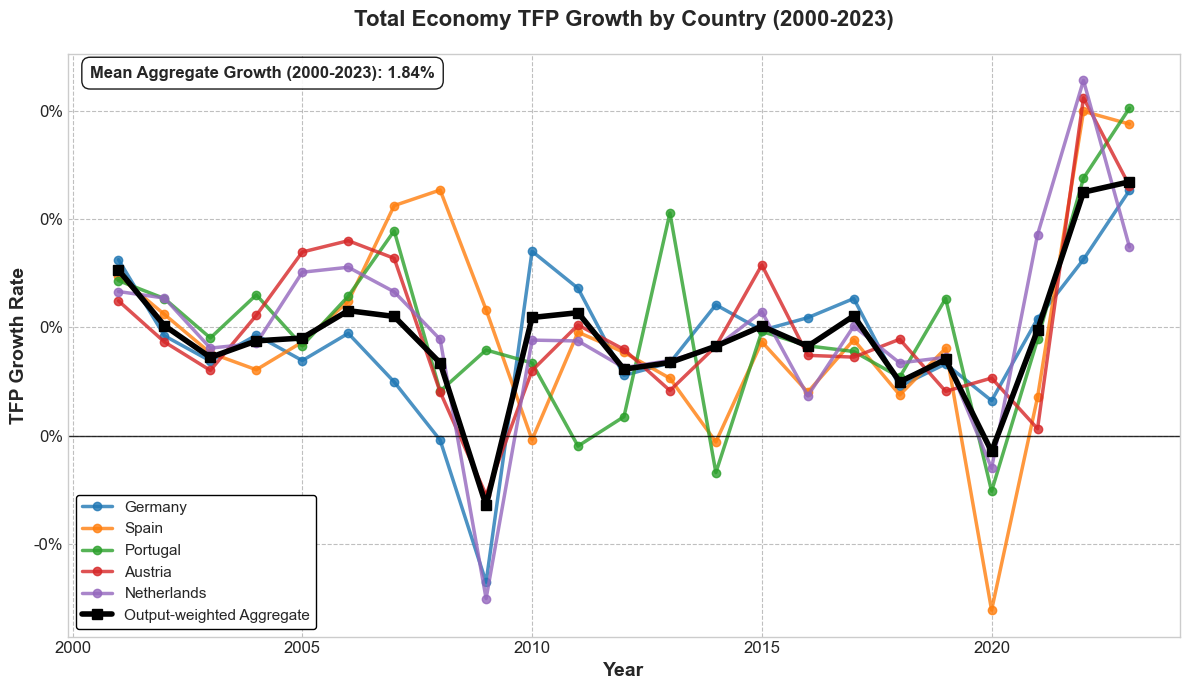

In [11]:
# =============================================================================
# Q1a: PLOT TOTAL ECONOMY TFP GROWTH
# =============================================================================

# Prepare data for plotting
total_df = df[df['sector'] == 'TOTAL'].copy()
total_agg_df = agg_tfp[agg_tfp['sector'] == 'TOTAL'].copy()

# Create figure with higher DPI and slightly clearer aspect ratio
fig, ax = plt.subplots(figsize=(12, 7))

# Plot individual country TFP growth
for country in COUNTRIES:
    country_data = total_df[total_df['country'] == country]
    ax.plot(country_data['year'], country_data['tfp_growth'], 
            marker='o', markersize=6, linewidth=2.5, alpha=0.8, 
            color=COLORS[country], label=COUNTRY_NAMES[country])

# Plot aggregate (weighted average)
ax.plot(total_agg_df['year'], total_agg_df['tfp_growth_aggregate'],
        color='black', linewidth=4.0, marker='s', markersize=7, # Thicker, bold aggregate
        label='Output-weighted Aggregate', zorder=10)

# Add horizontal line at zero
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.0, alpha=0.8) # Darker zero line

# Add mean aggregate growth as annotation with higher contrast box
ax.text(0.02, 0.98, f'Mean Aggregate Growth (2000-2023): {mean_total_growth:.2%}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.9))

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('TFP Growth Rate', fontsize=14, fontweight='bold')
ax.set_title('Total Economy TFP Growth by Country (2000-2023)', 
             fontsize=16, fontweight='bold', pad=20)

# Improved Legend
ax.legend(loc='lower left', framealpha=1.0, fontsize=11, edgecolor='black', frameon=True)

# Cleaner Grid
ax.grid(True, alpha=0.5, linestyle='--', color='gray') 
# Apply percentage formatting to y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Adjust ticks
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

# Save
save_path = OUTPUT_FIGURES / 'Q1a_total_tfp_growth.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved: {save_path}")

plt.show()

In [12]:
# =============================================================================
# Q1c: LOAD RECESSION INDICATOR
# =============================================================================

print("="*60)
print("Q1c: LOADING RECESSION INDICATOR")
print("="*60)

# Load recession data
recession = pd.read_excel(DATA_RAW / 'recession.xlsx')
print(f"✓ Loaded recession indicator: {len(recession)} observations")
print(f"\nRecession indicator columns: {recession.columns.tolist()}")
print(f"\nSample of recession data:")
print(recession.head(10))

# Identify recession years

print(f"\nData structure:")
print(recession.info())

Q1c: LOADING RECESSION INDICATOR
✓ Loaded recession indicator: 220 observations

Recession indicator columns: ['Dates', 'Peak excluded', 'Peak included']

Sample of recession data:
     Dates  Peak excluded  Peak included
0  1970.00              0              0
1  1970.25              0              0
2  1970.50              0              0
3  1970.75              0              0
4  1971.00              0              0
5  1971.25              0              0
6  1971.50              0              0
7  1971.75              0              0
8  1972.00              0              0
9  1972.25              0              0

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dates          220 non-null    float64
 1   Peak excluded  220 non-null    int64  
 2   Peak included  220 non-null    int64  
dtypes: float64(1), int64(2

In [13]:
# =============================================================================
# Q1c: PREPARE SECTORAL DATA WITH RECESSION INDICATORS
# =============================================================================

# Filter for the specific sectors (A, C, F, J, K, L - excluding TOTAL)
sectoral_sectors = ['A', 'C', 'F', 'J', 'K', 'L']
sectoral_df = df[df['sector'].isin(sectoral_sectors)].copy()

print("="*60)
print("PREPARING SECTORAL TFP GROWTH DATA")
print("="*60)
print(f"Sectors analyzed: {sectoral_sectors}")
print(f"Total observations: {len(sectoral_df)}")

# Calculate output-weighted aggregate for each sector
sectoral_agg = calculate_weighted_aggregate(
    sectoral_df,
    weight_var='gva',
    value_var='tfp_growth',
    group_vars=['sector', 'year']
)
sectoral_agg = sectoral_agg.rename(columns={'tfp_growth_weighted': 'tfp_growth_aggregate'})

# Calculate mean aggregate TFP growth for each sector
sector_means = sectoral_agg.groupby('sector')['tfp_growth_aggregate'].mean()
print(f"\n✓ Mean aggregate TFP growth by sector (2000-2023):")
for sector in sectoral_sectors:
    mean_val = sector_means.get(sector, np.nan)
    print(f"  Sector {sector}: {mean_val:.4%}")

# Prepare recession years list (will be determined after viewing recession data structure)
# For now, we'll create placeholder - UPDATE THIS after examining recession.xlsx structure

PREPARING SECTORAL TFP GROWTH DATA
Sectors analyzed: ['A', 'C', 'F', 'J', 'K', 'L']
Total observations: 720

✓ Mean aggregate TFP growth by sector (2000-2023):
  Sector A: 3.4250%
  Sector C: 2.2630%
  Sector F: 2.1533%
  Sector J: 1.5107%
  Sector K: 3.4761%
  Sector L: 1.7649%


Q1c: SECTORAL TFP GROWTH WITH RECESSION INDICATORS
Recession years identified: [1974, 1975, 1980, 1981, 1982, 1992, 1993, 2008, 2009, 2011, 2012, 2013, 2020]
Total recession years: 13

Sectors analyzed: ['A', 'C', 'F', 'J', 'K', 'L']
Total observations: 720

Mean aggregate TFP growth by sector (2001-2023):
  Sector A: 3.4250%
  Sector C: 2.2630%
  Sector F: 2.1533%
  Sector J: 1.5107%
  Sector K: 3.4761%
  Sector L: 1.7649%
✓ Figure saved (No Title): output\figures\Q1c_sectoral_tfp_recession.png


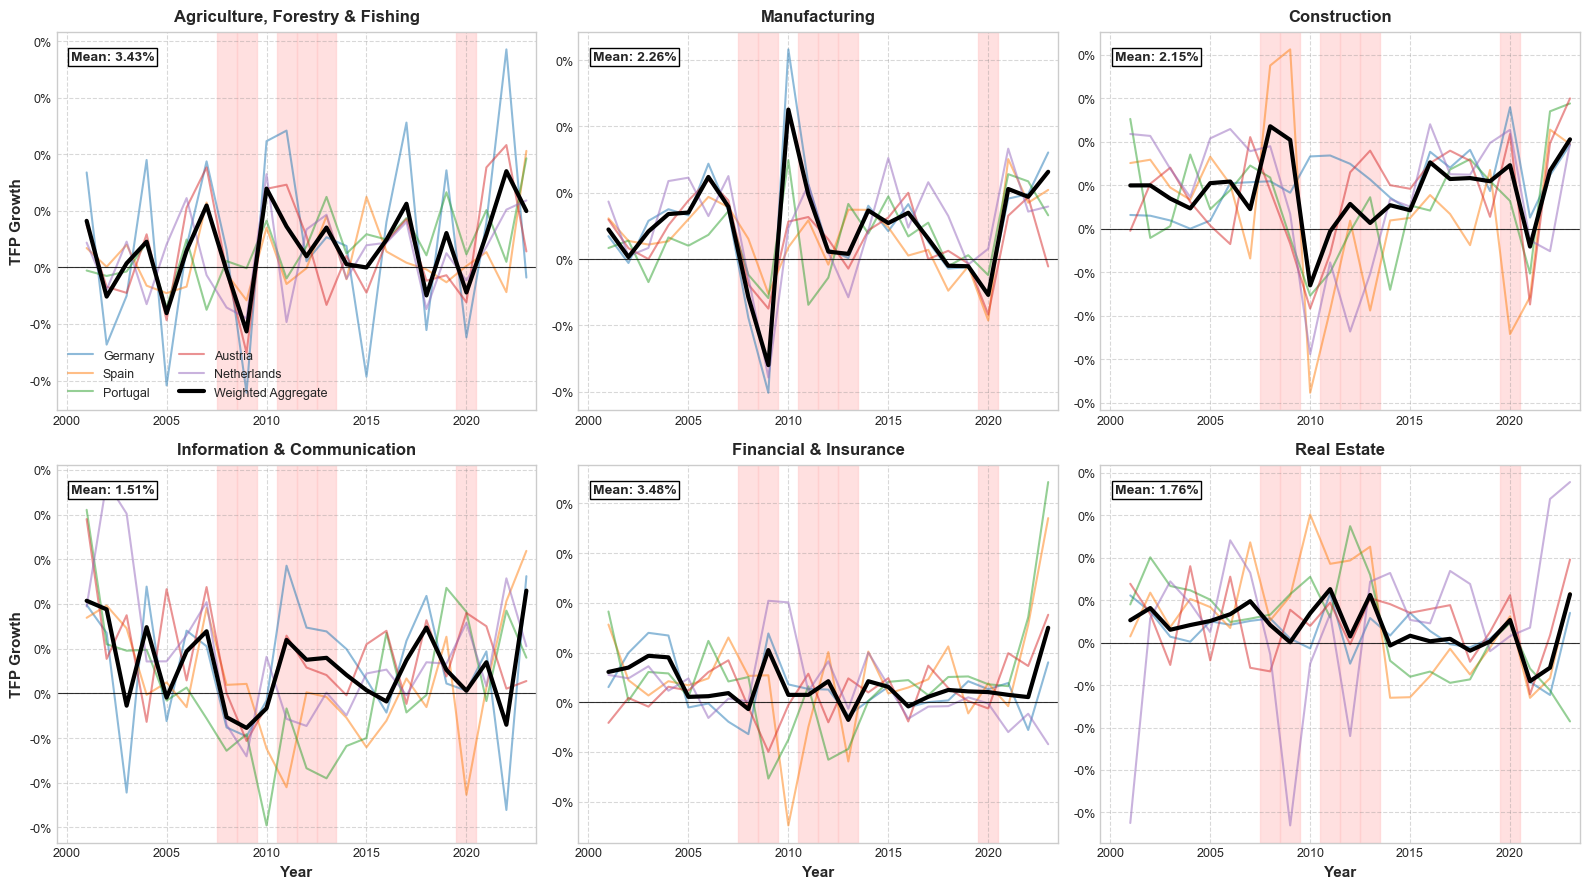


SUMMARY TABLE: MEAN AGGREGATE TFP GROWTH BY SECTOR
Sector                     Sector Name Mean Aggregate TFP Growth (2001-2023)
     A Agriculture, Forestry & Fishing                               3.4250%
     C                   Manufacturing                               2.2630%
     F                    Construction                               2.1533%
     J     Information & Communication                               1.5107%
     K           Financial & Insurance                               3.4761%
     L                     Real Estate                               1.7649%

✓ Summary table saved: output\tables\Q1c_sector_means.csv

Q1c COMPLETE


In [14]:
# =============================================================================
# Q1c: SECTORAL TFP GROWTH WITH RECESSION INDICATORS
# =============================================================================

print("="*60)
print("Q1c: SECTORAL TFP GROWTH WITH RECESSION INDICATORS")
print("="*60)

# Process recession indicator - use "Peak excluded" and aggregate to annual
# Mark a year as recession if ANY quarter in that year has recession=1
recession['year'] = recession['Dates'].apply(lambda x: int(x))
recession_annual = recession.groupby('year')['Peak excluded'].max().reset_index()
recession_annual.columns = ['year', 'recession']
recession_years = recession_annual[recession_annual['recession'] == 1]['year'].tolist()

print(f"Recession years identified: {recession_years}")
print(f"Total recession years: {len(recession_years)}\n")

# Filter for specific sectors (A, C, F, J, K, L - excluding TOTAL)
sectoral_sectors = ['A', 'C', 'F', 'J', 'K', 'L']
sectoral_df = df[df['sector'].isin(sectoral_sectors)].copy()

print(f"Sectors analyzed: {sectoral_sectors}")
print(f"Total observations: {len(sectoral_df)}\n")

# Calculate output-weighted aggregate for each sector
sectoral_agg = calculate_weighted_aggregate(
    sectoral_df,
    weight_var='gva',
    value_var='tfp_growth',
    group_vars=['sector', 'year']
)
sectoral_agg = sectoral_agg.rename(columns={'tfp_growth_weighted': 'tfp_growth_aggregate'})

# Calculate mean aggregate TFP growth for each sector (2001-2023, since 2000 has no growth)
sector_means = sectoral_agg.groupby('sector')['tfp_growth_aggregate'].mean()

print("Mean aggregate TFP growth by sector (2001-2023):")
for sector in sectoral_sectors:
    mean_val = sector_means.get(sector, np.nan)
    print(f"  Sector {sector}: {mean_val:.4%}")

# Create multi-panel figure
fig, axes = plt.subplots(2, 3, figsize=(16, 9)) # Slightly wider for clarity
axes = axes.flatten()

for idx, sector in enumerate(sectoral_sectors):
    ax = axes[idx]
    
    # Get data
    sector_data = sectoral_df[sectoral_df['sector'] == sector]
    sector_agg_data = sectoral_agg[sectoral_agg['sector'] == sector]
    
    # 1. Plot individual countries (thinner but visible)
    for country in COUNTRIES:
        country_data = sector_data[sector_data['country'] == country]
        ax.plot(country_data['year'], country_data['tfp_growth'],
                color=COLORS[country], alpha=0.5, linewidth=1.5, # Increased alpha/width
                label=COUNTRY_NAMES[country])
    
    # 2. Plot aggregate (Bold black line)
    ax.plot(sector_agg_data['year'], sector_agg_data['tfp_growth_aggregate'],
            color='black', linewidth=3.0, marker=None, # Removed markers to reduce clutter
            label='Weighted Aggregate', zorder=10)
    
    # 3. Recession Shading (Red)
    for rec_year in recession_years:
        if 2000 <= rec_year <= 2023:
            ax.axvspan(rec_year - 0.5, rec_year + 0.5, 
                       color='#ffcccc', alpha=0.6, zorder=0) # Lighter red, higher alpha
    
    # 4. Zero line
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.8)
    
    # 5. Annotation (Top Left)
    mean_growth = sector_means.get(sector, np.nan)
    ax.text(0.03, 0.95, f'Mean: {mean_growth:.2%}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top', fontweight='bold',
            bbox=dict(boxstyle='square,pad=0.2', facecolor='white', edgecolor='black', alpha=1.0))
    
    # 6. Formatting
    ax.set_title(SECTOR_NAMES[sector], fontsize=12, fontweight='bold', pad=8)
    
    if idx >= 3: # Only x-labels on bottom row
        ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    if idx % 3 == 0: # Only y-labels on left column
        ax.set_ylabel('TFP Growth', fontsize=11, fontweight='bold')
        
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    ax.set_xlim(1999.5, 2023.5)
    
    # Legend only in first panel
    if idx == 0:
        ax.legend(loc='lower left', fontsize=9, framealpha=1.0, edgecolor='black', ncol=2)

plt.tight_layout()
plt.savefig(OUTPUT_FIGURES / 'Q1c_sectoral_tfp_recession.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved (No Title): {OUTPUT_FIGURES / 'Q1c_sectoral_tfp_recession.png'}")
plt.show()

# Create and save summary table
summary_table = pd.DataFrame({
    'Sector': sectoral_sectors,
    'Sector Name': [SECTOR_NAMES[s] for s in sectoral_sectors],
    'Mean Aggregate TFP Growth (2001-2023)': [sector_means.get(s, np.nan) for s in sectoral_sectors]
})
summary_table['Mean Aggregate TFP Growth (2001-2023)'] = summary_table['Mean Aggregate TFP Growth (2001-2023)'].apply(lambda x: f'{x:.4%}')

print("\n" + "="*60)
print("SUMMARY TABLE: MEAN AGGREGATE TFP GROWTH BY SECTOR")
print("="*60)
print(summary_table.to_string(index=False))

# Save summary table
summary_table.to_csv(OUTPUT_TABLES / 'Q1c_sector_means.csv', index=False)
print(f"\n✓ Summary table saved: {OUTPUT_TABLES / 'Q1c_sector_means.csv'}")

print("\n" + "="*60)
print("Q1c COMPLETE")
print("="*60)

In [15]:
# =============================================================================
# Q2a: EXPORT DATA AND DESCRIPTIVE STATISTICS
# =============================================================================

"""
### Q2a: Export Data and Descriptive Statistics

**Objective:** Obtain annual exports by country and sector from Eurostat (ext_tec09),
merge with output data, and calculate exports as % of output.

**Data source:** Eurostat ext_tec09 - Exports by NACE Rev. 2 activity
**Sample:** 2012-2023 (as specified in the task)
"""

# -------------------------------------------------------------------------
# Load from API
# -------------------------------------------------------------------------

print("="*60)
print("Q2a: LOADING EXPORT DATA")
print("="*60)

# Eurostat API URL for ext_tec09
# Filters: Exports (EXP), World partner, NACE sectors, 5 countries, 2012-2023
EXPORT_API_URL = (
    'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/ext_tec09/1.0/*.*.*.*.*.*?c[freq]=A&c[unit]=THS_EUR&c[stk_flow]=EXP&c[nace_r2]=TOTAL,A,C,F,J,K,L&c[partner]=WORLD&c[geo]=DE,ES,NL,AT,PT&c[TIME_PERIOD]=2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
)

try:
    print("Downloading export data from Eurostat API...", end=" ")
    response = requests.get(EXPORT_API_URL)
    response.raise_for_status()
    exports_raw = pd.read_csv(StringIO(response.text))
    print(f"✓ ({len(exports_raw)} rows)")
    
    # Save raw data
    exports_raw.to_csv(DATA_RAW / 'ext_tec09_exports.csv', index=False)
    print(f"✓ Saved to {DATA_RAW / 'ext_tec09_exports.csv'}")
    
except Exception as e:
    print(f"✗ API failed: {e}")
    print("Attempting to load from local file...")
    exports_raw = pd.read_csv(DATA_RAW / 'ext_tec09_exports.csv')
    print(f"✓ Loaded from local file ({len(exports_raw)} rows)")

# Show what we got
print(f"\nColumns: {exports_raw.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(exports_raw.head())

# -------------------------------------------------------------------------
# CLEAN EXPORT DATA
# -------------------------------------------------------------------------

print("\n" + "="*60)
print("CLEANING EXPORT DATA")
print("="*60)

# Select and rename columns
exports = exports_raw[['geo', 'nace_r2', 'TIME_PERIOD', 'OBS_VALUE']].copy()
exports.columns = ['country', 'sector', 'year', 'exports']

# Convert types
exports['year'] = exports['year'].astype(int)
exports['exports'] = pd.to_numeric(exports['exports'], errors='coerce')

# Drop missing values
n_before = len(exports)
exports = exports.dropna()
n_dropped = n_before - len(exports)
if n_dropped > 0:
    print(f"⚠ Dropped {n_dropped} rows with missing values")

print(f"✓ Cleaned export data: {len(exports)} observations")
print(f"  Countries: {sorted(exports['country'].unique())}")
print(f"  Sectors: {sorted(exports['sector'].unique())}")
print(f"  Years: {exports['year'].min()}-{exports['year'].max()}")

# -------------------------------------------------------------------------
# MERGE WITH OUTPUT (GVA) DATA
# -------------------------------------------------------------------------

print("\n" + "="*60)
print("MERGING EXPORTS WITH OUTPUT DATA")
print("="*60)

# Filter main dataset to 2012+ (as required)
df_2012 = df[df['year'] >= 2012].copy()
print(f"Output data (2012+): {len(df_2012)} observations")

# Merge
df_exports = df_2012.merge(
    exports,
    on=['country', 'sector', 'year'],
    how='inner'
)

print(f"After merge: {len(df_exports)} observations")
print(f"  (Lost {len(df_2012) - len(df_exports)} rows in merge)")

# Convert exports from thousand euro to million euro
df_exports['exports'] = df_exports['exports'] / 1000

# Calculate export share (exports as % of output)
df_exports['export_share'] = (df_exports['exports'] / df_exports['gva']) * 100

print(f"\n✓ Calculated export_share = (exports / gva) × 100")

# Save merged data
df_exports.to_csv(DATA_PROCESSED / 'exports_merged.csv', index=False)
print(f"✓ Saved to {DATA_PROCESSED / 'exports_merged.csv'}")

# -------------------------------------------------------------------------
# DESCRIPTIVE STATISTICS TABLE
# -------------------------------------------------------------------------

print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS: EXPORT SHARE (%)")
print("="*60)

# Overall statistics
print("\n--- Overall ---")
overall = df_exports['export_share'].describe()
print(f"  N:      {overall['count']:.0f}")
print(f"  Mean:   {overall['mean']:.2f}%")
print(f"  Std:    {overall['std']:.2f}%")
print(f"  Min:    {overall['min']:.2f}%")
print(f"  P25:    {overall['25%']:.2f}%")
print(f"  Median: {overall['50%']:.2f}%")
print(f"  P75:    {overall['75%']:.2f}%")
print(f"  Max:    {overall['max']:.2f}%")

# By sector
print("\n--- By Sector ---")
sector_stats = df_exports.groupby('sector')['export_share'].agg([
    'count', 'mean', 'std', 'min', 'median', 'max'
]).round(2)
sector_stats.columns = ['N', 'Mean', 'Std', 'Min', 'Median', 'Max']
sector_stats.index = [SECTOR_NAMES.get(s, s) for s in sector_stats.index]
print(sector_stats)

# Save table
sector_stats.to_csv(OUTPUT_TABLES / 'Q2a_descriptive_stats.csv')
print(f"\n✓ Table saved: {OUTPUT_TABLES / 'Q2a_descriptive_stats.csv'}")

print("\n" + "="*60)
print("Q2a COMPLETE")
print("="*60)

Q2a: LOADING EXPORT DATA
✓ Saved to data\raw\ext_tec09_exports.csv

Columns: ['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency', 'unit', 'Unit of measure', 'stk_flow', 'Stock or flow', 'nace_r2', 'Statistical classification of economic activities in the European Community (NACE Rev. 2)', 'partner', 'Geopolitical entity (partner)', 'geo', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'Time', 'OBS_VALUE', 'Observation value', 'OBS_FLAG', 'Observation status (Flag) V2 structure', 'CONF_STATUS', 'Confidentiality status (flag)']

First 5 rows:
  STRUCTURE          STRUCTURE_ID                        STRUCTURE_NAME freq Time frequency     unit Unit of measure stk_flow Stock or flow nace_r2  \
0  dataflow  ESTAT:EXT_TEC09(1.0)  Trade by NACE Rev. 2 activity sector    A         Annual  THS_EUR   Thousand euro      EXP       Exports       A   
1  dataflow  ESTAT:EXT_TEC09(1.0)  Trade by NACE Rev. 2 activity sector    A         Annual  THS_EUR   Thousand euro      EXP  

Q2b: PRODUCTIVITY-EXPORT RELATIONSHIP FIGURES
Dataset: 345 observations

--- Figure 1: Total Economy ---
✓ Saved: output\figures\Q2b_total_productivity_exports.png


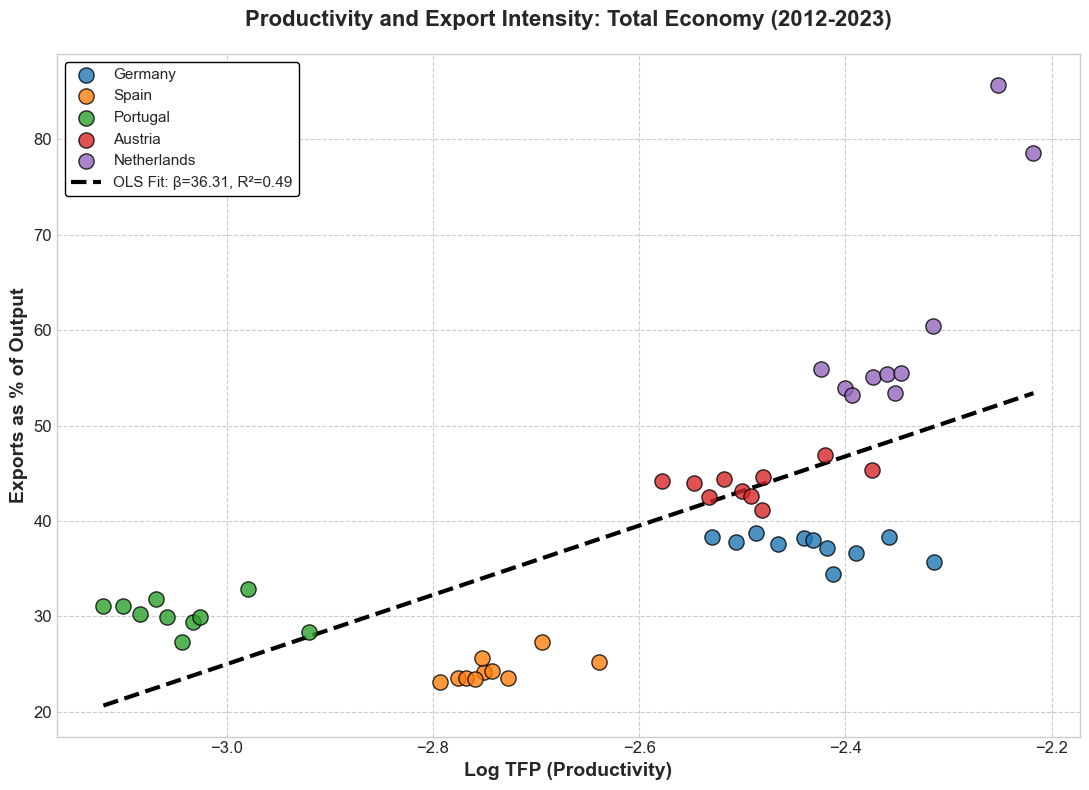


--- Figure 2: Sectoral Panels ---
✓ Saved: output\figures\Q2b_sectoral_productivity_exports.png


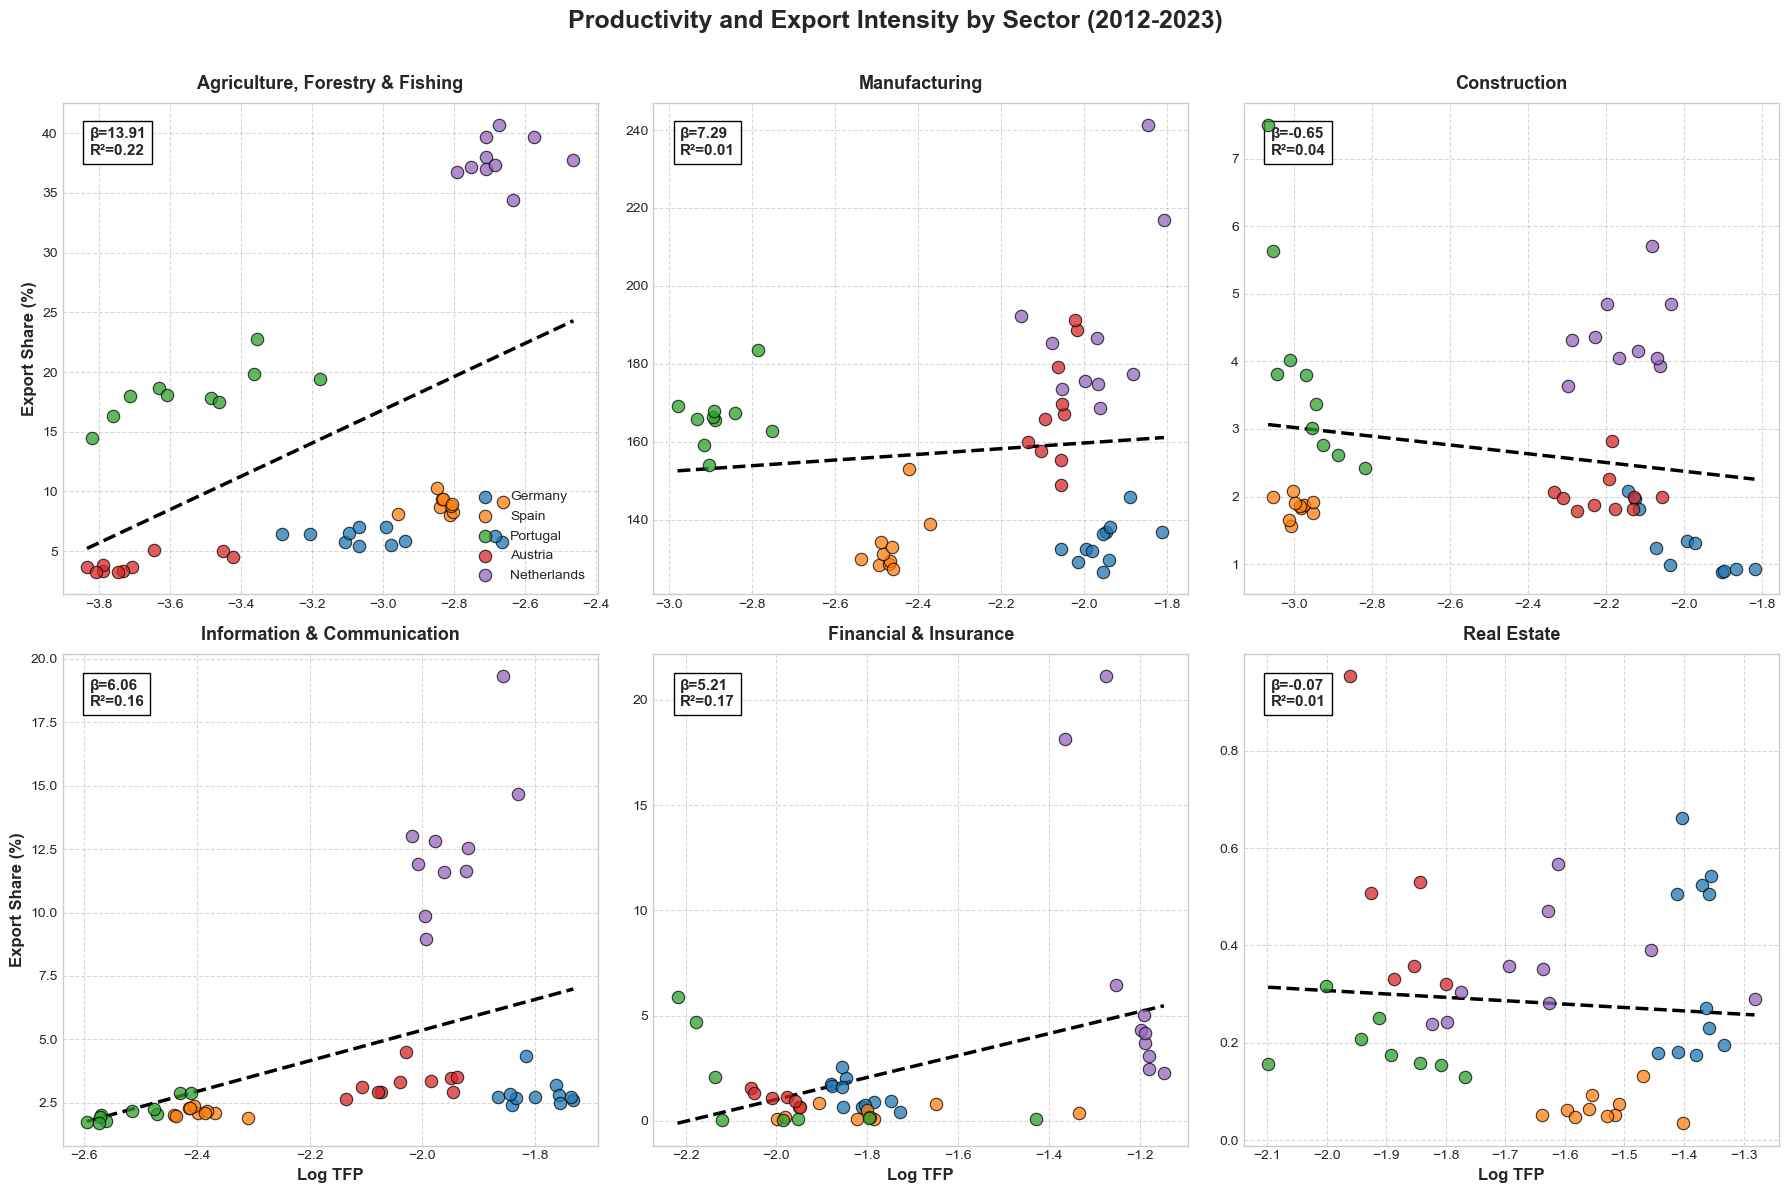

Q2b COMPLETE


In [16]:
# =============================================================================
# Q2b: PRODUCTIVITY-EXPORT RELATIONSHIP FIGURES
# =============================================================================

"""
### Q2b: Productivity-Export Relationship Figures

**Objective:** Produce two figures showing relationship between log productivity 
and exports as % of output:
1. One for total economy (TOTAL)
2. One with separate panel for each sector (A, C, F, J, K, L)
"""

print("="*60)
print("Q2b: PRODUCTIVITY-EXPORT RELATIONSHIP FIGURES")
print("="*60)

# Calculate log productivity
df_exports['log_tfp'] = np.log(df_exports['tfp'])

# Check for invalid values
n_invalid = df_exports['log_tfp'].isna().sum()
if n_invalid > 0:
    print(f"⚠ Removing {n_invalid} observations with invalid log(TFP)")
    df_exports = df_exports[df_exports['log_tfp'].notna()]

print(f"Dataset: {len(df_exports)} observations")


# -------------------------------------------------------------------------
# FIGURE 1: TOTAL ECONOMY
# -------------------------------------------------------------------------

print("\n--- Figure 1: Total Economy ---")

df_total = df_exports[df_exports['sector'] == 'TOTAL'].copy()

# Increased figure size slightly for better aspect ratio
fig, ax = plt.subplots(figsize=(11, 8))

# Scatter plot by country
for country in COUNTRIES:
    cdata = df_total[df_total['country'] == country]
    ax.scatter(cdata['log_tfp'], cdata['export_share'],
               color=COLORS[country], 
               s=120,               # Much larger markers
               alpha=0.8,           # Higher opacity
               label=COUNTRY_NAMES[country], 
               edgecolors='black',  # Black outlines for definition
               linewidth=1.0,       # Thicker outlines
               zorder=5)

# Fit and plot regression line
x = df_total['log_tfp'].values
y = df_total['export_share'].values
slope, intercept, r_value, p_value, _ = stats.linregress(x, y)

x_line = np.linspace(x.min(), x.max(), 100)
y_line = intercept + slope * x_line

# Thick, dashed black line for regression
ax.plot(x_line, y_line, 'k--', linewidth=3.0, zorder=4,
        label=f'OLS Fit: β={slope:.2f}, R²={r_value**2:.2f}')

# Formatting
ax.set_xlabel('Log TFP (Productivity)', fontsize=14, fontweight='bold')
ax.set_ylabel('Exports as % of Output', fontsize=14, fontweight='bold')
ax.set_title('Productivity and Export Intensity: Total Economy (2012-2023)',
             fontsize=16, fontweight='bold', pad=20)

# Legend with solid white background to hide gridlines
ax.legend(loc='upper left', fontsize=11, framealpha=1.0, 
          facecolor='white', edgecolor='black', frameon=True)

# Grid and Ticks
ax.grid(True, alpha=0.4, linestyle='--', color='gray')
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
save_path_1 = OUTPUT_FIGURES / 'Q2b_total_productivity_exports.png'
plt.savefig(save_path_1, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path_1}")
plt.show()


# -------------------------------------------------------------------------
# FIGURE 2: SECTORAL PANELS
# -------------------------------------------------------------------------

print("\n--- Figure 2: Sectoral Panels ---")

sectoral_sectors = ['A', 'C', 'F', 'J', 'K', 'L']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, sector in enumerate(sectoral_sectors):
    ax = axes[idx]
    sector_data = df_exports[df_exports['sector'] == sector]
    
    # Scatter by country
    for country in COUNTRIES:
        cdata = sector_data[sector_data['country'] == country]
        ax.scatter(cdata['log_tfp'], cdata['export_share'],
                   color=COLORS[country], 
                   s=80,                # Large markers for subplots
                   alpha=0.75, 
                   label=COUNTRY_NAMES[country] if idx == 0 else None,
                   edgecolors='black',  # Black outlines
                   linewidth=0.8,
                   zorder=5)
    
    # Regression line
    x = sector_data['log_tfp'].values
    y = sector_data['export_share'].values
    
    if len(x) > 2:
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        x_line = np.linspace(x.min(), x.max(), 50)
        y_line = intercept + slope * x_line
        
        # Thicker regression line
        ax.plot(x_line, y_line, 'k--', linewidth=2.5, zorder=4)
        
        # Stats annotation with high-contrast white box
        stats_text = f'β={slope:.2f}\nR²={r_value**2:.2f}'
        ax.text(0.05, 0.95, stats_text,
                transform=ax.transAxes, fontsize=11, verticalalignment='top', fontweight='bold',
                bbox=dict(boxstyle='square,pad=0.4', facecolor='white', edgecolor='black', alpha=1.0))
    
    # Formatting
    title_text = SECTOR_NAMES.get(sector, sector)
    ax.set_title(title_text, fontsize=13, fontweight='bold', pad=10)
    
    # Only label outer axes to reduce clutter
    if idx >= 3:
        ax.set_xlabel('Log TFP', fontsize=12, fontweight='bold')
    if idx % 3 == 0:
        ax.set_ylabel('Export Share (%)', fontsize=12, fontweight='bold')
        
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')
    ax.tick_params(axis='both', labelsize=10)

# Legend only in first panel, with white background
axes[0].legend(loc='lower right', fontsize=10, framealpha=1.0, 
               facecolor='white', edgecolor='black')

# Main Title
fig.suptitle('Productivity and Export Intensity by Sector (2012-2023)',
             fontsize=18, fontweight='bold', y=0.99)

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for suptitle
save_path_2 = OUTPUT_FIGURES / 'Q2b_sectoral_productivity_exports.png'
plt.savefig(save_path_2, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path_2}")
plt.show()

print("="*60)
print("Q2b COMPLETE")
print("="*60)

### Q3a
---

In [17]:
# =============================================================================
# Q3a: ECONOMETRIC ANALYSIS - EXPORTS AND PRODUCTIVITY
# =============================================================================

print("="*60)
print("Q3a: ESTIMATING THE PRODUCTIVITY-EXPORT RELATIONSHIP")
print("="*60)

# -------------------------------------------------------------------------
# 1. PREPARE PANEL DATA
# -------------------------------------------------------------------------

# Exclude 'TOTAL' to focus on sectoral variation
df_panel = df_exports[df_exports['sector'] != 'TOTAL'].copy()

# Ensure numeric types and handle log transformation
df_panel['log_tfp'] = np.log(pd.to_numeric(df_panel['tfp'], errors='coerce'))
df_panel['export_share'] = pd.to_numeric(df_panel['export_share'], errors='coerce')

# Drop any rows with inf or NaN
df_panel = df_panel.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_tfp', 'export_share'])

print(f"Panel: {len(df_panel)} obs | {df_panel['country'].nunique()} countries | "
      f"{df_panel['sector'].nunique()} sectors | {df_panel['year'].nunique()} years")

# -------------------------------------------------------------------------
# 2. ESTIMATE PROGRESSIVE MODELS
# -------------------------------------------------------------------------

# Dependent variable
y = df_panel['export_share'].astype(float)

# Independent variable (with constant)
X_base = sm.add_constant(df_panel[['log_tfp']].astype(float))

# Create Fixed Effects dummies
country_fe = pd.get_dummies(df_panel['country'], prefix='c', drop_first=True).astype(int)
sector_fe = pd.get_dummies(df_panel['sector'], prefix='s', drop_first=True).astype(int)
year_fe = pd.get_dummies(df_panel['year'], prefix='y', drop_first=True).astype(int)

# --- MODEL 1: Pooled OLS (No Fixed Effects) ---
print("\nEstimating Model 1: Pooled OLS...")
model1 = sm.OLS(y, X_base).fit(cov_type='HC1')

# --- MODEL 2: Country Fixed Effects ---
print("Estimating Model 2: Country FE...")
X_cfe = pd.concat([X_base, country_fe], axis=1)
model2 = sm.OLS(y, X_cfe).fit(cov_type='HC1')

# --- MODEL 3: Country + Sector Fixed Effects ---
print("Estimating Model 3: Country + Sector FE...")
X_csfe = pd.concat([X_base, country_fe, sector_fe], axis=1)
model3 = sm.OLS(y, X_csfe).fit(cov_type='HC1')

# --- MODEL 4: Country + Sector + Year Fixed Effects (Two-Way FE) ---
print("Estimating Model 4: Country + Sector + Year FE...")
X_full = pd.concat([X_base, country_fe, sector_fe, year_fe], axis=1)
model4 = sm.OLS(y, X_full).fit(cov_type='HC1')

print("All models estimated.\n")

# -------------------------------------------------------------------------
# 3. CREATE RESULTS TABLE
# -------------------------------------------------------------------------

def format_coef(model, var='log_tfp'):
    """Format coefficient with significance stars."""
    coef = model.params[var]
    pval = model.pvalues[var]
    if pval < 0.01:
        return f"{coef:.3f}***"
    elif pval < 0.05:
        return f"{coef:.3f}**"
    elif pval < 0.10:
        return f"{coef:.3f}*"
    else:
        return f"{coef:.3f}"

def format_se(model, var='log_tfp'):
    """Format standard error in parentheses."""
    return f"({model.bse[var]:.3f})"

# Build results table
results_table = pd.DataFrame({
    'Variable': ['ln(TFP)', '', 'Observations', 'R²', 'Adj. R²', 
                 'Country FE', 'Sector FE', 'Year FE'],
    '(1)': [
        format_coef(model1), format_se(model1),
        int(model1.nobs), f"{model1.rsquared:.3f}", f"{model1.rsquared_adj:.3f}",
        'No', 'No', 'No'
    ],
    '(2)': [
        format_coef(model2), format_se(model2),
        int(model2.nobs), f"{model2.rsquared:.3f}", f"{model2.rsquared_adj:.3f}",
        'Yes', 'No', 'No'
    ],
    '(3)': [
        format_coef(model3), format_se(model3),
        int(model3.nobs), f"{model3.rsquared:.3f}", f"{model3.rsquared_adj:.3f}",
        'Yes', 'Yes', 'No'
    ],
    '(4)': [
        format_coef(model4), format_se(model4),
        int(model4.nobs), f"{model4.rsquared:.3f}", f"{model4.rsquared_adj:.3f}",
        'Yes', 'Yes', 'Yes'
    ]
})

# -------------------------------------------------------------------------
# 4. DISPLAY RESULTS
# -------------------------------------------------------------------------

print("="*60)
print("REGRESSION RESULTS: Export Share on Log TFP")
print("="*60)
print(results_table.to_string(index=False))
print("-"*60)
print("Notes: Robust (HC1) standard errors in parentheses.")
print("*** p<0.01, ** p<0.05, * p<0.10")

# -------------------------------------------------------------------------
# 5. SAVE RESULTS
# -------------------------------------------------------------------------

# Save formatted table
results_table.to_csv(OUTPUT_TABLES / 'Q3a_regression_table.csv', index=False)
print(f"✓ Table saved: {OUTPUT_TABLES / 'Q3a_regression_table.csv'}")

# Save detailed results for each model
detailed_results = pd.DataFrame({
    'Model': ['(1) Pooled', '(2) Country FE', '(3) Country+Sector FE', '(4) Full FE'],
    'Coefficient': [model1.params['log_tfp'], model2.params['log_tfp'], 
                    model3.params['log_tfp'], model4.params['log_tfp']],
    'Std_Error': [model1.bse['log_tfp'], model2.bse['log_tfp'],
                  model3.bse['log_tfp'], model4.bse['log_tfp']],
    'P_Value': [model1.pvalues['log_tfp'], model2.pvalues['log_tfp'],
                model3.pvalues['log_tfp'], model4.pvalues['log_tfp']],
    'R_Squared': [model1.rsquared, model2.rsquared, model3.rsquared, model4.rsquared],
    'Adj_R_Squared': [model1.rsquared_adj, model2.rsquared_adj, 
                      model3.rsquared_adj, model4.rsquared_adj],
    'N': [model1.nobs, model2.nobs, model3.nobs, model4.nobs]
})
detailed_results.to_csv(OUTPUT_TABLES / 'Q3a_regression_detailed.csv', index=False)
print(f"✓ Detailed results saved: {OUTPUT_TABLES / 'Q3a_regression_detailed.csv'}")

print("\n" + "="*60)
print("Q3a COMPLETE")
print("="*60)

Q3a: ESTIMATING THE PRODUCTIVITY-EXPORT RELATIONSHIP
Panel: 294 obs | 5 countries | 6 sectors | 11 years

Estimating Model 1: Pooled OLS...
Estimating Model 2: Country FE...
Estimating Model 3: Country + Sector FE...
Estimating Model 4: Country + Sector + Year FE...
All models estimated.

REGRESSION RESULTS: Export Share on Log TFP
    Variable     (1)     (2)      (3)      (4)
     ln(TFP)  -4.638 -6.137* 6.432*** 5.081***
             (4.084) (3.650)  (1.992)  (1.894)
Observations     294     294      294      294
          R²   0.002   0.016    0.973    0.974
     Adj. R²  -0.001  -0.001    0.972    0.972
  Country FE      No     Yes      Yes      Yes
   Sector FE      No      No      Yes      Yes
     Year FE      No      No       No      Yes
------------------------------------------------------------
Notes: Robust (HC1) standard errors in parentheses.
*** p<0.01, ** p<0.05, * p<0.10
✓ Table saved: output\tables\Q3a_regression_table.csv
✓ Detailed results saved: output\tables\Q3a_

## **3: Task C Analysis**
---

Solving value function iteration...
Converged after 137 iterations.
Value function iteration complete.

Q3: STATIONARY DISTRIBUTION

--- Q3a: Computing Stationary Distribution ---
Distribution converged after 227 iterations.
Distribution sums to: 1.000000

Mean assets: 2.746
Mean income: 0.972
Mean consumption: 1.054

--- Q3b: Plotting Distributions ---
✓ Figure saved: output\figures\Q3b_distributions.png


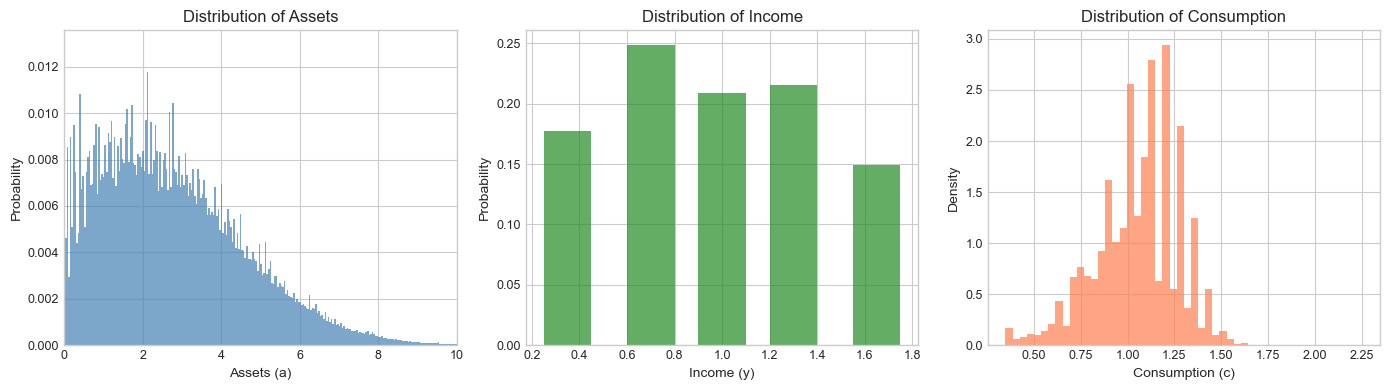

Q4: MARGINAL PROPENSITY TO CONSUME

--- Q4a: Computing MPC ---
Average MPC: 0.0960
MPC range: [0.0000, 0.3907]

--- Q4b: Calibration Target ---

Target MPC: 0.25

Source: Johnson, Parker & Souleles (2006, AER) find MPCs of 20-40% from tax rebates.

Parameter to adjust: β (discount factor)
- Lower β → more impatient → less savings → higher MPC


Calibration over β:
  β = 0.90  →  MPC = 0.1856
  β = 0.92  →  MPC = 0.1541
  β = 0.94  →  MPC = 0.1172
  β = 0.95  →  MPC = 0.0960
  β = 0.96  →  MPC = 0.0699

TASK C COMPLETE


In [18]:
# =============================================================================
# TASK C: VALUE FUNCTION ITERATION AND STATIONARY DISTRIBUTION
# =============================================================================

# Set parameters:
beta = 0.95                                          
sigma = 2.0                                          

# Asset grid parameters:         
a_min = 0.0                                          
a_max = 20.0                                         
a_size = 500                                         
a_grid = np.linspace(a_min, a_max, a_size)           
r = 0.03                                             

# Income process parameters:
y_states = np.array([0.35, 0.7, 1.0, 1.3, 1.65])
y_transition = np.array(
    [[0.5, 0.3, 0.1, 0.05, 0.05],
     [0.2, 0.5, 0.2, 0.05, 0.05],
     [0.1, 0.2, 0.4, 0.2, 0.1],
     [0.05, 0.1, 0.2, 0.5, 0.15],
     [0.05, 0.05, 0.1, 0.3, 0.5]]
)

num_y = len(y_states)
num_a = len(a_grid)
num_states = num_y * num_a

def utility(c):
    c_used = np.maximum(c, np.finfo(float).eps)  
    if sigma == 1:
        return np.log(c_used)
    else:
        return (c_used**(1 - sigma)) / (1 - sigma)
    
state_grid = np.array([(a, y) for y in y_states for a in a_grid])

V_init = np.zeros(num_states) 

consumption = np.zeros((num_states, num_a))
for i_y in range(num_y):
    for i_a in range(num_a):
        state_index = i_y * num_a + i_a
        for j_a in range(num_a):
            a_next = a_grid[j_a]
            income = y_states[i_y]
            consumption[state_index, j_a] = income + (1+r)*a_grid[i_a] - a_next

utility_matrix = utility(consumption)

tol = 0.001
max_iter = 1000
V = V_init.copy()

print("Solving value function iteration...")
for it in range(max_iter):
    V_reshaped = V.reshape((num_y, num_a))
    EVPrime_reshaped = np.zeros_like(utility_matrix)

    for i_y in range(num_y):
        y_transition_reshaped = y_transition[i_y].reshape((num_y, 1))
        EVPrime_y = np.matmul(V_reshaped.T, y_transition_reshaped)
        EVPrime_reshaped[(i_y * num_a):((i_y + 1) * num_a), :] = np.repeat(EVPrime_y.T, num_a, axis=0)

    V_til = utility_matrix + beta * EVPrime_reshaped
    V_new = np.max(V_til, axis=1)
    policy_indices = np.argmax(V_til, axis=1)
    
    diff = np.max(np.abs(V_new - V))
    V = V_new
    if diff < tol:
        print(f'Converged after {it} iterations.')
        break

AssetPolicy = policy_indices.reshape((num_y, num_a))
consumption_policy = np.zeros(num_states)
for i in range(num_states):
    consumption_policy[i] = consumption[i, policy_indices[i]]

ConsumptionPolicy = consumption_policy.reshape((num_y, num_a))

print("Value function iteration complete.\n")


# =============================================================================
# Q3: STATIONARY DISTRIBUTION
# =============================================================================

print("="*60)
print("Q3: STATIONARY DISTRIBUTION")
print("="*60)

# Q3a: Compute stationary distribution
print("\n--- Q3a: Computing Stationary Distribution ---")

mu = np.ones(num_states) / num_states
max_iter_dist = 5000
tol_dist = 1e-8

for it in range(max_iter_dist):
    mu_new = np.zeros(num_states)
    
    for i_state in range(num_states):
        i_y = i_state // num_a
        a_next_idx = policy_indices[i_state]
        
        for i_y_next in range(num_y):
            next_state = i_y_next * num_a + a_next_idx
            mu_new[next_state] += mu[i_state] * y_transition[i_y, i_y_next]
    
    diff_dist = np.max(np.abs(mu_new - mu))
    mu = mu_new
    
    if diff_dist < tol_dist:
        print(f"Distribution converged after {it+1} iterations.")
        break

print(f"Distribution sums to: {mu.sum():.6f}")

# Marginal distributions
mu_a = np.zeros(num_a)
mu_y = np.zeros(num_y)

for i_y in range(num_y):
    for i_a in range(num_a):
        state_idx = i_y * num_a + i_a
        mu_a[i_a] += mu[state_idx]
        mu_y[i_y] += mu[state_idx]

print(f"\nMean assets: {np.sum(mu * state_grid[:, 0]):.3f}")
print(f"Mean income: {np.sum(mu * state_grid[:, 1]):.3f}")
print(f"Mean consumption: {np.sum(mu * consumption_policy):.3f}")


# Q3b: Plot distributions
print("\n--- Q3b: Plotting Distributions ---")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Assets
axes[0].bar(a_grid, mu_a, width=a_grid[1]-a_grid[0], alpha=0.7, color='steelblue')
axes[0].set_xlabel('Assets (a)')
axes[0].set_ylabel('Probability')
axes[0].set_title('Distribution of Assets')
axes[0].set_xlim(0, 10)

# Income
axes[1].bar(y_states, mu_y, width=0.2, alpha=0.7, color='forestgreen')
axes[1].set_xlabel('Income (y)')
axes[1].set_ylabel('Probability')
axes[1].set_title('Distribution of Income')

# Consumption
axes[2].hist(consumption_policy, bins=50, weights=mu, alpha=0.7, color='coral', density=True)
axes[2].set_xlabel('Consumption (c)')
axes[2].set_ylabel('Density')
axes[2].set_title('Distribution of Consumption')

plt.tight_layout()
save_path = OUTPUT_FIGURES / 'Q3b_distributions.png'
plt.savefig(save_path, dpi=300)
print(f"✓ Figure saved: {save_path}")
plt.show()


# =============================================================================
# Q4: MARGINAL PROPENSITY TO CONSUME
# =============================================================================

print("="*60)
print("Q4: MARGINAL PROPENSITY TO CONSUME")
print("="*60)

# Q4a: Compute MPC
print("\n--- Q4a: Computing MPC ---")

delta_a = 1.0
mpc_by_state = np.zeros(num_states)

for i_y in range(num_y):
    for i_a in range(num_a):
        state_idx = i_y * num_a + i_a
        c_current = consumption_policy[state_idx]
        a_shocked = a_grid[i_a] + delta_a
        
        if a_shocked >= a_max:
            c_shocked = ConsumptionPolicy[i_y, -1]
        else:
            idx_low = np.searchsorted(a_grid, a_shocked) - 1
            idx_low = max(0, idx_low)
            idx_high = min(idx_low + 1, num_a - 1)
            
            if idx_low == idx_high:
                c_shocked = ConsumptionPolicy[i_y, idx_low]
            else:
                weight = (a_shocked - a_grid[idx_low]) / (a_grid[idx_high] - a_grid[idx_low])
                c_shocked = (1 - weight) * ConsumptionPolicy[i_y, idx_low] + weight * ConsumptionPolicy[i_y, idx_high]
        
        mpc_by_state[state_idx] = (c_shocked - c_current) / delta_a

avg_mpc = np.sum(mu * mpc_by_state)

print(f"Average MPC: {avg_mpc:.4f}")
print(f"MPC range: [{mpc_by_state.min():.4f}, {mpc_by_state.max():.4f}]")


# Q4b: Calibration
print("\n--- Q4b: Calibration Target ---")
print("""
Target MPC: 0.25

Source: Johnson, Parker & Souleles (2006, AER) find MPCs of 20-40% from tax rebates.

Parameter to adjust: β (discount factor)
- Lower β → more impatient → less savings → higher MPC
""")

print("\nCalibration over β:")

def solve_for_mpc(beta_val):
    """Solve model and return average MPC for given beta."""
    V_cal = np.zeros(num_states)
    
    for _ in range(max_iter):
        V_reshaped = V_cal.reshape((num_y, num_a))
        EVPrime = np.zeros_like(utility_matrix)
        
        for i_y in range(num_y):
            EV = np.matmul(V_reshaped.T, y_transition[i_y].reshape((num_y, 1)))
            EVPrime[(i_y * num_a):((i_y + 1) * num_a), :] = np.repeat(EV.T, num_a, axis=0)
        
        V_til = utility_matrix + beta_val * EVPrime
        V_new = np.max(V_til, axis=1)
        pol_idx = np.argmax(V_til, axis=1)
        
        if np.max(np.abs(V_new - V_cal)) < tol:
            break
        V_cal = V_new
    
    # Consumption policy
    c_pol = np.array([consumption[i, pol_idx[i]] for i in range(num_states)])
    C_pol = c_pol.reshape((num_y, num_a))
    
    # Distribution
    mu_cal = np.ones(num_states) / num_states
    for _ in range(2000):
        mu_new = np.zeros(num_states)
        for i_s in range(num_states):
            i_y = i_s // num_a
            for i_y_n in range(num_y):
                mu_new[i_y_n * num_a + pol_idx[i_s]] += mu_cal[i_s] * y_transition[i_y, i_y_n]
        mu_cal = mu_new
    
    # MPC
    mpc = np.zeros(num_states)
    for i_y in range(num_y):
        for i_a in range(num_a):
            idx = i_y * num_a + i_a
            a_new = a_grid[i_a] + 1.0
            if a_new >= a_max:
                c_new = C_pol[i_y, -1]
            else:
                il = min(max(np.searchsorted(a_grid, a_new) - 1, 0), num_a - 2)
                w = (a_new - a_grid[il]) / (a_grid[il+1] - a_grid[il])
                c_new = (1 - w) * C_pol[i_y, il] + w * C_pol[i_y, il + 1]
            mpc[idx] = c_new - c_pol[idx]
    
    return np.sum(mu_cal * mpc)

beta_vals = [0.90, 0.92, 0.94, 0.95, 0.96]
for b in beta_vals:
    m = solve_for_mpc(b)
    print(f"  β = {b:.2f}  →  MPC = {m:.4f}")

print("\n" + "="*60)
print("TASK C COMPLETE")
print("="*60)